# Experimento  de Aristarco

## Tamanho Angular do Sol e da Lua

```{important}
O primeiro ingrediente do método de Aristarco é a observação de que o tamanho angular do Sol e da Lua são essencialmente iguais. O que é evidenciado em eclipses solares totais.

Vamos utilizar dados públicos de eclipses e a biblioteca `sunpy` para verificarmos esta informação.

```

In [1]:
from src.astroufcg.astronomy import setup, make_observer
from src.astroufcg.grecia import aristarco
from PIL import Image
import numpy as np
from sunpy.net import Fido
from sunpy.net import attrs as a
import sunpy.map
import sunpy
import matplotlib.pyplot as plt
import astropy.units as u
import copy
from sunpy.map import make_fitswcs_header
from sunpy.time import parse_time
from sunpy.coordinates import Helioprojective, sun
from astropy.coordinates import EarthLocation
from astropy.coordinates import SkyCoord

Na imagem da eclipse solar fazemos o seguinte processamento#: 
- Equalização de Histograma para evidenciar nuances de intensidade.
- Desfoque gaussiano para eliminar pontas e arestas que dificultam a determinação de contornos.
- Transformamos a imagem em uma máscara binária.
- Aplicamos um algoritmo que determina os contornos existentes na imagem.
- Para cada contorno fazemos um ajste de mínimos quadrados para um círculo.

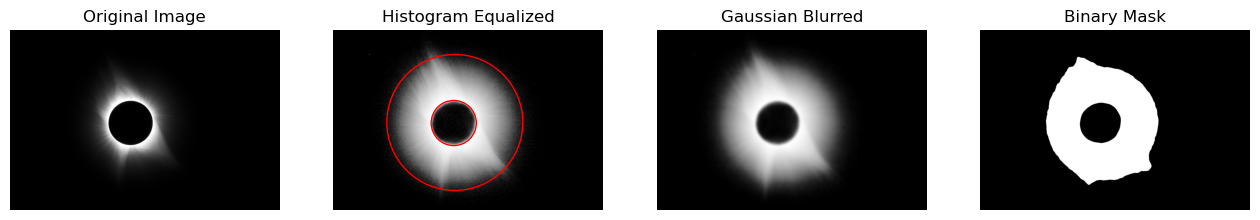

In [2]:
from PIL import Image
SAMPLE_PHOTO = "../../../data/eclipse/total_solar_eclipse2017.jpg"
tags = aristarco.read_exif(SAMPLE_PHOTO)
moon_image = Image.open(SAMPLE_PHOTO).convert("L")
moon_image = moon_image.transpose(Image.FLIP_TOP_BOTTOM)
moon_data = np.array(moon_image)
results_moon, ax_moon, fig_moon = aristarco.get_disk(moon_data, plot=True)
result_moon = results_moon[np.vstack(results_moon)[:, 0].argmin()]

Vamos repetir o procedimento para uma imagem científica, no formato FITs, que contém informações sobre as coordenadas.

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

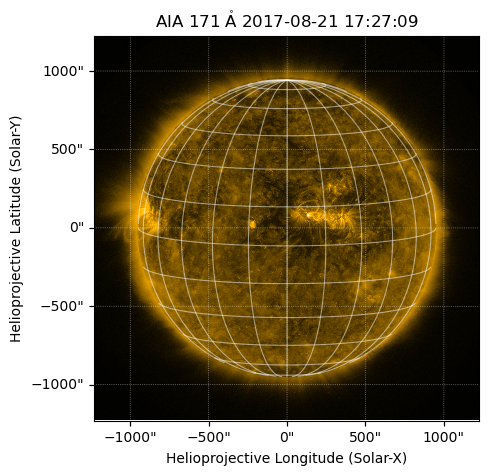

In [3]:
aia_result = Fido.search(
    a.Time("2017-08-21 17:27:00", "2017-08-21 17:45:00"),
    a.Instrument("AIA"),
    a.Wavelength(171 * u.Angstrom),
)
files = Fido.fetch(aia_result[0, 0], site="NSO", path="../../../data/eclipse/")
aia_map = sunpy.map.Map(files[0])
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={"projection": aia_map})
aia_map.plot(axes=ax, autoalign=True)
aia_map.draw_grid(axes=ax)
plt.show()

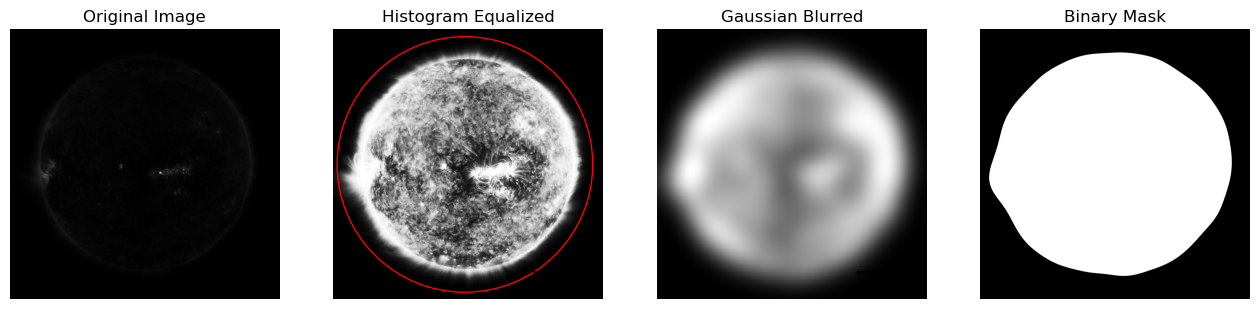

In [4]:
results_aia, ax_aia, fig_aia = aristarco.get_disk(aia_map.data, sigma=171, plot=True)

Esta imagem contém dados suficientes para a determinação do diâmetro angular da Lua. A partir da **plate scale** do mapa e do tamanho a lua em pixels.

In [5]:
half_moon_angular = u.Quantity(aia_map.scale) * results_aia[0][0] * u.pix
print(f"Diâmetro angular da Lua: {(2 * half_moon_angular).to(u.deg)}")

# Determinando plate_scale da imagem da Lua
moon_scale = (
    u.Quantity(aia_map.scale) * results_aia[0][0] / result_moon[0]
)

# Construção do cabeçalho FITS
# Observador
loc = EarthLocation(
    lat=tags["lat"],
    lon=tags["lon"],
    height=0,
)
observer = loc.get_itrs(parse_time(tags["time"]))
frame = sunpy.coordinates.Helioprojective(
    observer=observer, obstime=parse_time(tags["time"])
)
moon_coord = SkyCoord(
    sunpy.coordinates.get_body_heliographic_stonyhurst(
        "moon", parse_time(tags["time"]), observer=observer))
solar_rotation_angle = sun.orientation(loc, parse_time(tags["time"]))
moon_hpc = moon_coord.transform_to(frame)
center_pix = results_moon[1].astype(int)[1:]
# Aplicamos uma máscara para tornar o fundo transparente
moon_data = copy.deepcopy(moon_data)
moon_data[moon_data < 30] = False  # Ajuste o valor conforme
header_moon = make_fitswcs_header(
    moon_data,
    moon_hpc,
    reference_pixel=u.Quantity(center_pix, unit="pixel"),
    scale=moon_scale,
    rotation_angle=solar_rotation_angle,
    exposure=tags["exposure_time"],
    instrument=tags["camera_model"],
    observatory=tags["author"],
)
eclipse_map = sunpy.map.Map(moon_data, header_moon)

Diâmetro angular da Lua: [0.64681687 0.64681687] deg


2025-07-19 16:49:33 - sunpy - INFO: Apparent body location accounts for 1.23 seconds of light travel time


INFO: Apparent body location accounts for 1.23 seconds of light travel time [sunpy.coordinates.ephemeris]


2025-07-19 16:49:33 - sunpy - INFO: Using mesh-based autoalignment


INFO: Using mesh-based autoalignment [sunpy.map.mapbase]


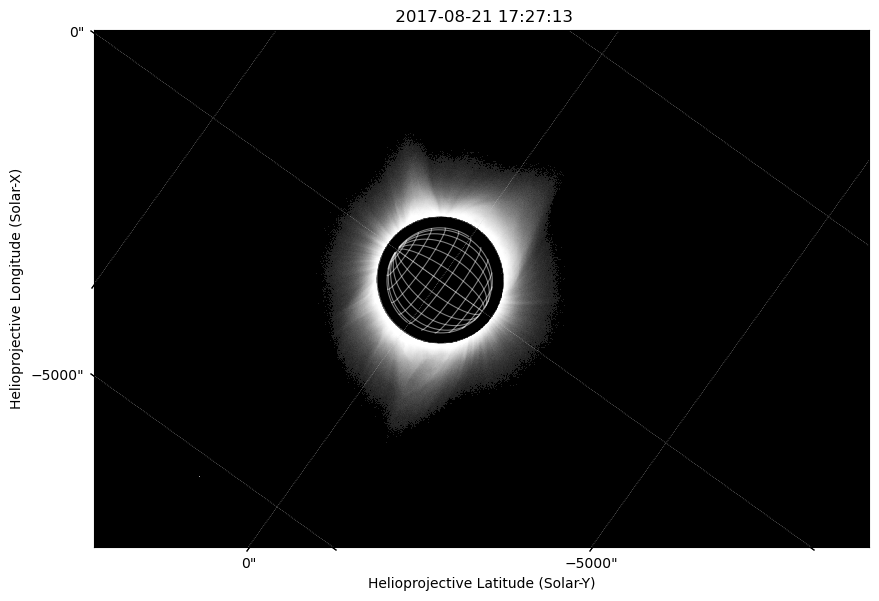

In [6]:
fig = plt.figure(figsize=(10, 15))
ax = plt.subplot(projection=eclipse_map)

# Set the axes background to black.
ax.set_facecolor("k")
# Plot the AIA image.
aia_map.plot()
# Plot the eclipse image
eclipse_map.plot()
# Draw heliographic and helioprojective grids
eclipse_map.draw_grid()
ax.coords.grid(color="lightgray", alpha=0.7, linewidth=.5)

## Geometria da Experiência

In [7]:
import pyvista as pv
from pyvista import examples
import astropy.constants as const
from skyfield import almanac
from src.astroufcg.astronomy import setup
import pandas as pd
import osmnx as ox
pv.set_jupyter_backend('trame')
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [8]:
from src.astroufcg.astronomy import ts, eph, lua, terra, sol, make_observer

In [9]:
start = ts.ut1(-200, 1, 1)
end = ts.ut1(-200, 12, 31)
t, y = almanac.find_discrete(start, end, almanac.moon_phases(eph))

date = [time for time, phase in zip(t, y) if phase == 1][0]
site_01 = "Alexandria, Egypt"
location = pd.DataFrame([list(ox.geocode(site_01))], columns=["lat", "lon"]).iloc[0]
observer = make_observer(location)
moon_obs = observer.at(date).observe(lua)
sun_obs = observer.at(date).observe(sol)
ra_moon, dec_moon, distance_moon = moon_obs.radec()
ra_sun, dec_sun, distance_sun = sun_obs.radec()


R_moon = distance_moon.to(u.km) * np.sin(np.radians(half_moon_angular[0].to(u.rad)))
R_sun = distance_sun.to(u.km) * np.sin(np.radians(half_moon_angular[0].to(u.rad)))
R_earth = const.R_earth

In [10]:
# Tamanhos para o modelo
_Rt = 1
_angle = np.radians(80)
_R_sun = (R_sun / R_earth).decompose()
_R_moon = (R_moon / R_earth).decompose()
_Ds = 30 * _Rt
_Rs, _Rm = 2 * _Rt, 0.8 * _Rt
_Dm = _Ds * np.cos(_angle)
_Pt, _Ps, _Pm = (0, 0, 0), (_Ds, 0, 0), (_Dm * np.cos(_angle), _Dm * np.sin(_angle), 0)

In [11]:
_terra, _sol, _lua = [pv.Sphere(radius=_R, center=_P, theta_resolution=100, phi_resolution=100) for _R, _P in zip([_Rt, _Rs, _Rm], [_Pt, _Ps, _Pm])]

_terra.texture_map_to_sphere(inplace=True)
_sol.texture_map_to_sphere(inplace=True)
_lua.texture_map_to_sphere(inplace=True)
moon_texture = pv.Texture("../../../data/textures/2k_moon.jpg")
sun_texture = pv.Texture("../../../data/textures/2k_sun.jpg")
earth_texture = examples.load_globe_texture()
lines = pv.MultipleLines(np.array([_Pt, _Ps, _Ps, _Pm, _Pm, _Pt]))
sun_light = pv.Light(
    position=(_Ds - _Rs, 0, 0),
    focal_point=_Pm,
    intensity=50,
    color="lightgray",
    positional=True,
    cone_angle=30,
    shadow_attenuation=0.3,
)
ambient_light = pv.Light(
    position=(-_Ds / 2, 0, 0),
    focal_point=_Pm,
    intensity=5,
    color="lightgray",
    positional=True,
    cone_angle=60,
    shadow_attenuation=0.3,
)

In [ ]:
pl = pv.Plotter(notebook=True, lighting="three lights", polygon_smoothing=True, window_size=[1000, 400])
pl.add_mesh(lines, color="maroon", line_width=5)
pl.add_light(sun_light)
pl.add_light(ambient_light)
pl.set_background("black")

pl.add_mesh(
    _terra, texture=earth_texture, smooth_shading=True, ambient=0.8, diffuse=0.5
)
pl.add_mesh(_sol, texture=sun_texture, smooth_shading=True, opacity=0.6)
pl.add_mesh(
    _lua,
    texture=moon_texture,
    smooth_shading=True,
    ambient=0.8,
    diffuse=0.5,
)
pl.enable_anti_aliasing("fxaa")
pl.enable_eye_dome_lighting()
pl.camera_position = "xy"
pl.camera.azimuth = 180
pl.camera.zoom(2)
pl.save_graphic("../../00_images/cap_01/lua_solar_eclipse.svg")
pl.show(jupyter_backend="trame")


2025-07-19 16:51:48 - wslink.backends.aiohttp - INFO: client 4e3a4cf374ca4e41b3fa1c7d1b495206 disconnected
2025-07-19 16:51:48 - wslink.backends.aiohttp - INFO: No more connections, scheduling shutdown
2025-07-19 16:51:48 - aiohttp.access - INFO: 127.0.0.1 [19/Jul/2025:16:51:39 -0300] "GET /ws HTTP/1.1" 101 0 "-" "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Code/1.101.2 Chrome/134.0.6998.205 Electron/35.5.1 Safari/537.36"


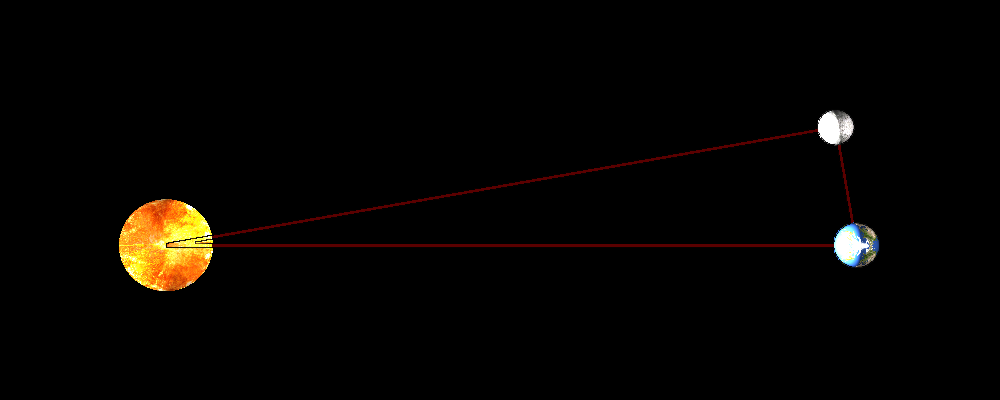

In [13]:
from IPython.display import SVG, display
display(SVG("../../00_images/cap_01/lua_solar_eclipse.svg"))

## Fazendo a Observação da meia Lua

Agora nós vamos implementar esta observação utilizando o Skyfield. Para fazer o gráfico em coordenadas esféricas eu vou aproveitar os recursos de **WCS** do astropy.

- Definimos um WCS com projeção zenital.
- Baixamos dados de constelações
- Criamos uma lista com as constelações do zodíaco.
- Acessamos o catálogo Hipparco no serviço Vizier para obter as posições das estrelas do céu com magnitude inferior  6.
- Construimos as posições do Sol e da Lua para o dia de lua quarto crescente.
- Construímos as posições das estrelas levando em conta a precessão dos equinócios.
- Sobrepomos a eclíptica e o equador celeste.
- Fazemos um gráfico do céu.


In [14]:
from skyfield.api import (
    load,
    Loader,
    Star,
    load_constellation_map,
    load_constellation_names,
)
from skyfield.data import stellarium
from astropy.coordinates import Angle, SkyCoord
from astropy.wcs import WCS
from astropy import units as u
import numpy as np
import pandas as pd


# Cria um WCS para projeção estereográfica (AZP)
wcs = WCS(naxis=2)
wcs.wcs.ctype = ["AZP-SIN", "AZP-SIN"]  # Projeção azimutal estereográfica
wcs.wcs.crpix = [512, 512]  # Centro da imagem (pixel reference)
wcs.wcs.crval = [0, 90]  # Centro em Az=0°, Alt=90° (zênite)
wcs.wcs.cdelt = [-0.1, 0.1]  # Escala em graus/pixel
wcs.wcs.cunit = ["deg", "deg"]

# (Opcional) Configura parâmetros específicos da projeção AZP
wcs.wcs.set_pv([(2, 1, 45)])  # Ângulo de projeção (45° para estereográfica)

const_dict = dict(load_constellation_names())
constellation_at = load_constellation_map()

url = (
    "https://raw.githubusercontent.com/Stellarium/stellarium/"
    "eb47095a9282cf6b981f6e37fe1ea3a3ae0fd167"
    "/skycultures/modern_st/constellationship.fab"
)
load = Loader("../../../data/skyfield")
with load.open(url) as f:
    constellations = stellarium.parse_constellations(f)

edges = [edge for name, edges in constellations for edge in edges]
edges_star1 = [star1 for star1, star2 in edges]
edges_star2 = [star2 for star1, star2 in edges]

zodiac_abbrv = [
    "Ari",
    "Tau",
    "Gem",
    "Cnc",
    "Leo",
    "Vir",
    "Lib",
    "Sco",
    "Sgr",
    "Cap",
    "Aqr",
    "Psc",
]

from astroquery.vizier import Vizier

Vizier.clear_cache()
catalog = "I/239/hip_main"
vizier = Vizier(
    columns=["HIP", "_RA.icrs", "_DE.icrs", "Vmag", "Plx", "pmRA", "pmDE"],
    catalog=catalog,
    column_filters={"Vmag": "<=5.0"},
)
vizier.ROW_LIMIT = -1

In [15]:
obs_lua = observer.at(date).observe(lua)
lua_Alt, lua_Az, _ = obs_lua.apparent().altaz()
obs_sol = observer.at(date).observe(sol).apparent()
sol_Alt, sol_Az, _ = obs_sol.altaz()
lua_pixel = wcs.world_to_pixel(lua_Az.degrees * u.deg, lua_Alt.degrees * u.deg)
sol_pixel = wcs.world_to_pixel(sol_Az.degrees * u.deg, sol_Alt.degrees * u.deg)

In [16]:
hipparcos = vizier.query_constraints()[0].to_pandas()
hipparcos["ra_hours"] = Angle(hipparcos["_RA.icrs"], unit=u.hourangle).hour
hipparcos["dec_degrees"] = hipparcos["_DE.icrs"]
hipparcos["epoch_year"] = 2000.0
_start_csts = np.concatenate([np.array(const[1]).ravel() for const in constellations])
_csts_names = np.concatenate(
    [np.array([const[0]] * 2 * len(const[1])) for const in constellations]
)
df_csts = pd.DataFrame(
    {
        "HIP": _start_csts,
        "cst": _csts_names,
    }
)
df_csts = df_csts.drop_duplicates(subset="HIP").set_index("HIP")
df = hipparcos.copy()
limiting_magnitude = 5.0

all_stars = Star.from_dataframe(df)

stars = observer.at(date).observe(all_stars)
Alt, Az, _ = stars.apparent().altaz()
_RA, _DEC, _ = stars.radec(epoch=date)
var_names = ["Alt", "Az", "RA", "DEC"]
for varname, var in zip(var_names, [Alt, Az, _RA, _DEC]):
    df[varname] = var.degrees
df = df.set_index("HIP")
df = df.join(df_csts, how="left")
df["x"], df["y"] = wcs.world_to_pixel(df.Az.values * u.deg, df.Alt.values * u.deg)

In [17]:
from astropy.time import TimeDelta
from skyfield.positionlib import Apparent
ra_hours = np.arange(-48, 48, 0.1)

interval = ts.from_astropy(date.to_astropy() + np.arange(300) * TimeDelta(5 * u.min))
obs_ecliptic = observer.at(interval).observe(sol).apparent()
alt_ecliptic, az_ecliptic, _ = obs_ecliptic.altaz()

fake_star = Star(
    ra_hours=ra_hours * u.hourangle, dec_degrees=np.zeros_like(ra_hours) * u.deg
)
obs_equatorial = observer.at(date).observe(fake_star).apparent()
equatorial_alt, equatorial_az, _ = obs_equatorial.altaz()

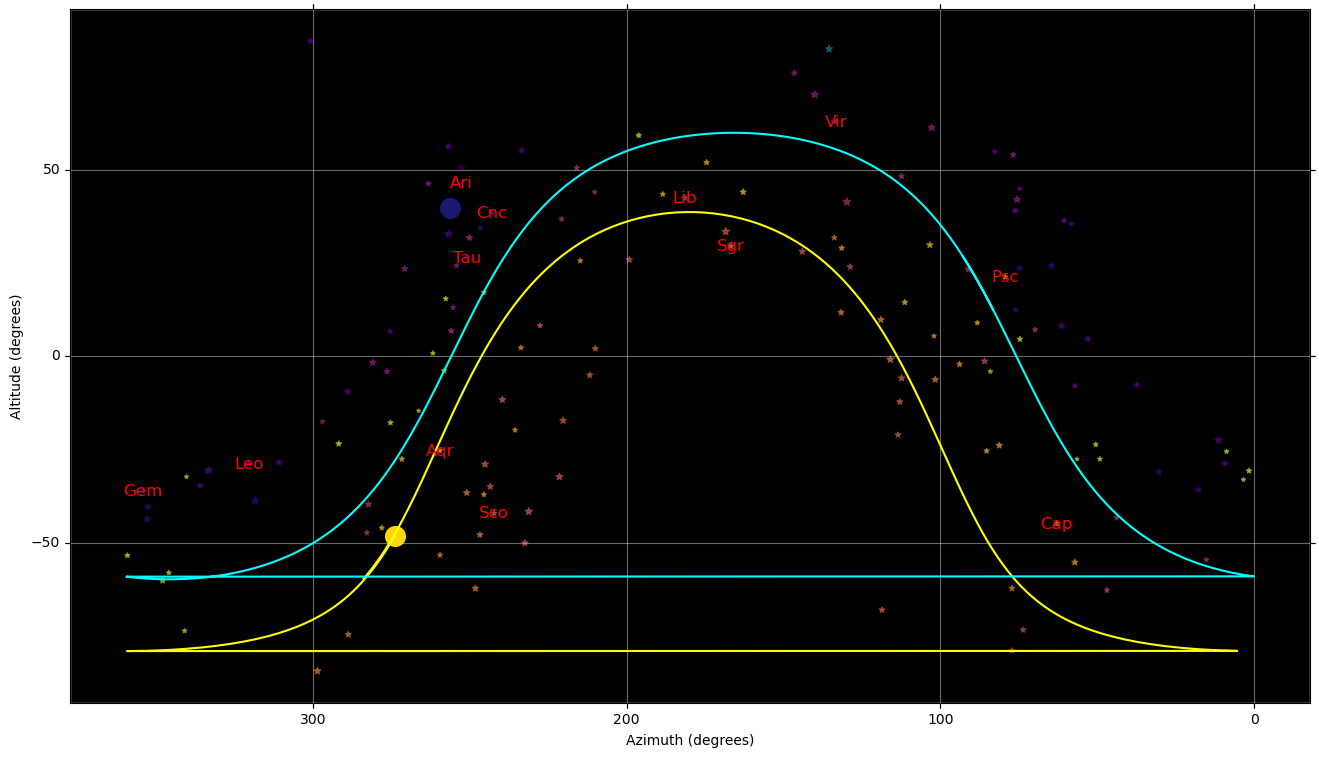

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

n_colors = len(zodiac_abbrv)  # Number of colors to generate
colormap_name = "plasma"  # Choose a colormap
cmap = mpl.colormaps[colormap_name]
color_positions = np.linspace(0, 1, n_colors)
colors = cmap(color_positions)

def get_size(magnitude):
    """Calculate the size of the star based on its magnitude."""
    return 20 * (6 - magnitude) / 6 

fig, ax = plt.subplots(figsize=(16, 9), subplot_kw=dict(projection=wcs))
ax.set_facecolor("black")
Az = ax.coords[0]
Alt = ax.coords[1]
Az.set_axislabel("Azimuth (degrees)")
Alt.set_axislabel("Altitude (degrees)")
ax.coords.grid(color="lightgray", alpha=0.5, linestyle="solid")

ax.plot(*wcs.wcs_world2pix(az_ecliptic.degrees, alt_ecliptic.degrees, 0), color="yellow", label="Ecliptic")
ax.plot(*wcs.wcs_world2pix(equatorial_az.degrees, equatorial_alt.degrees, 0), color="cyan", label="Equatorial")

zodiac = df[df.cst.isin(zodiac_abbrv)].groupby("cst")
for cst, group in zodiac:
    ax.text(
        group.iloc[0, :].x,
        group.iloc[0, :].y,
        cst,
        color="red",
        fontsize=12,
        ha="center",
        va="center",
    )
    ax.scatter(
        group.x.values,
        group.y.values,
        s=2 * get_size(group.Vmag.values),
        c=colors[zodiac_abbrv.index(cst)],
        marker="*",
        label=cst,
        alpha=0.5,
    )
ax.scatter(
    *lua_pixel,
    s=200,
    c="midnightblue",
    marker="o",
    label="Lua",
)
ax.scatter(
    *sol_pixel,
    s=200,
    c="gold",
    marker="o",
    label="Sol",
)

plt.show()

## Analisando os Resultados

$$ 
\cos \theta = \frac{D_\mathrm{moon}}{D_\odot} \\ 
\frac{R_\mathrm{moon}}{D_\mathrm{moon}} = \frac{R_\odot}{D_\odot} \\
\ \\
R_\mathrm{moon} = R_\odot \cos \theta \\
D_\mathrm{moon} = D_\odot \cos \theta 
$$

Para obter os ângulos entre os planetas podemos utilizar as posições como coordenadas cartesianas e construir os ângulos com a lei dos cossenos.

In [19]:
interval = ts.from_astropy(date.to_astropy() + np.arange(-10, 10) * TimeDelta(5 * u.min))

# Obter posições relativas no sistema baricêntrico
pos_earth = terra.at(interval).position.km
pos_moon = lua.at(interval).position.km
pos_sun = sol.at(interval).position.km

# Vetores entre os corpos (para formar o triângulo)
vec_TE = pos_earth - pos_moon  # Terra ← Lua
vec_SE = pos_earth - pos_sun  # Terra ← Sol
vec_SM = pos_moon - pos_sun  # Lua ← Sol

# Normas dos vetores (lados do triângulo)
a = np.linalg.norm(vec_SM, axis=0)  # lado oposto ao vértice Terra
b = np.linalg.norm(vec_SE, axis=0)  # lado oposto ao vértice Lua
c = np.linalg.norm(vec_TE, axis=0)  # lado oposto ao vértice Sol


# Função para calcular ângulo a partir da Lei dos Cossenos
def law_of_cosines(a, b, c):
    return np.arccos((b**2 + c**2 - a**2) / (2 * b * c))



# Ângulos internos (em radianos)
angle_Terra = law_of_cosines(a, b, c)
angle_Lua = law_of_cosines(b, c, a)
angle_Sol = law_of_cosines(c, a, b)

In [20]:
idx = (np.degrees(angle_Lua)>=90).argmin()
t_halfmoon = interval[idx]
delta_t = (t_halfmoon.to_astropy() - date.to_astropy()).to(u.min)

theta_almanac = np.degrees(angle_Terra[10])
theta_halfmoon = np.degrees(angle_Terra[idx])

Aqui surge uma questão interessante, a data indicada na rotina almanac esta um pouco defasada: 

In [21]:
print("Horário do meio da Lua Quarto Crescente:", date.ut1_strftime("%Y-%m-%d %H:%M:%S"))
print(f"Horário em que a Lua está a 90° do Sol: {t_halfmoon.ut1_strftime('%Y-%m-%d %H:%M:%S')}")
print(f"ângulo na data almanac $\hat\{{Terra\}}$: {theta_almanac:.2f}")
print(f"ângulo em 90° $\hat\{{Terra\}}$: {theta_halfmoon:.2f}")

Horário do meio da Lua Quarto Crescente: -200-01-19 19:15:50
Horário em que a Lua está a 90° do Sol: -200-01-19 18:55:50
ângulo na data almanac $\hat\{Terra\}$: 89.99
ângulo em 90° $\hat\{Terra\}$: 89.84


In [22]:
from IPython.display import display, Math, Latex
display(Math(r"\Delta t = " + f"{delta_t.to(u.min):.2f}"))
display(Latex(f"$$ \\frac{{R_{{\odot}}}}{{R_{{moon}}}} = {1/np.cos(np.radians(theta_almanac)):.2f}$$"))
display(
    Latex(
        f"$$ \\frac{{R_{{\odot}}}}{{R_{{moon}}}} = {1 / np.cos(np.radians(theta_halfmoon)):.2f}$$"
    )
)

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Vinte minutos de diferença e poderíamos errar por duas ordens de grandeza. Note que é necessário medir um ângulo, com precisão, na ordem de **0.5** minutos de arco. O ângulo entre dois objetos que sequer estão no céu ao mesmo tempo!!